In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms
from transformers import AutoImageProcessor, ViTForImageClassification


/home/henrik/anaconda3/envs/CV-tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification

class CustomViTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomViTModel, self).__init__()
        # Load the pre-trained Vision Transformer and extract the backbone
        self.vit_backbone = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_labels,
            output_attentions=True,
            ignore_mismatched_sizes=True,
            attn_implementation="eager"
        ).vit
        
        # Add custom fully connected layers
        self.custom_classifier = nn.Sequential(
            nn.Linear(768, 1024),  
            nn.Linear(1024, num_labels)
        )
    
    def forward(self, x, output_attentions=False):
        # Forward pass through the Vision Transformer backbone
        vit_outputs = self.vit_backbone(x, output_attentions=output_attentions)
        print(type(vit_outputs))
        print(type(vit_outputs.attentions))
        # Extract the last hidden state (we use the CLS token embedding as the feature)
        vit_features = vit_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        
        # Forward pass through the custom classifier
        output = self.custom_classifier(vit_features)
        
        # Return the attention weights if requested
        if output_attentions:
            print('here')
            return output, vit_outputs.attentions
        return output


# Note: The code below are adapted from: https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map

In [3]:
def load_model_weights(model, model_path):
    # Assuming your saved model weights are compatible with PyTorch's save format
    state_dict = torch.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict)
    return model

def get_attention_map(model, img, get_mask=False):
    model.eval()  # Set the model to evaluation mode
    
    # Transform the image
    image = img.resize((224, 224))  # Resize to match ViT input
    image = np.array(image, dtype=np.float32)  # Convert to float32
    image = (image - 127.5) / 127.5  # Normalize to range [-1, 1]
    image = torch.from_numpy(image).permute(2, 0, 1)  # Change HWC to CHW format for PyTorch
    x = image.unsqueeze(0)  # Add batch dimension
    
    # Ensure the tensor is on the same device as the model
    x = x.to(next(model.parameters()).device)

    # Forward pass through the model to get attention weights
    with torch.no_grad():
        _, vit_outputs = model(x, output_attentions=True)  # Extract attention weights directly from the model
        att_mat = vit_outputs  # This should correctly extract the attention weights
    print(att_mat)
    # Stack the attention weights and average across all heads
    att_mat = torch.stack(att_mat).squeeze(1)
    att_mat = torch.mean(att_mat, dim=1)
    
    # Add identity matrix for residual connections and normalize
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively multiply the weight matrices to get joint attention
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])
    
    # Extract the attention map from the last layer
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    
    # Resize and prepare mask
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * np.array(img)).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original', fontsize=20)  # Increase font size
    ax2.set_title('Attention Map', fontsize=20)  # Increase font size
    ax1.imshow(original_img)
    ax2.imshow(att_map)
    
    # Remove the axes
    ax1.axis('off')
    ax2.axis('off')
    
    plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_541737/1217039316.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`.

<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
<class 'tuple'>
here
(tensor([[[[6.2564e-01, 6.9652e-04, 5.7872e-04,  ..., 3.5266e-03,
           3.8112e-03, 4.6371e-03],
          [8.8812e-01, 8.6952e-03, 4.6962e-03,  ..., 2.0087e-05,
           5.3498e-05, 4.3106e-05],
          [9.0058e-01, 5.1765e-03, 4.6852e-03,  ..., 2.7242e-05,
           6.6472e-05, 4.1179e-05],
          ...,
          [1.9857e-01, 1.4679e-06, 1.7344e-06,  ..., 4.0692e-01,
           3.5994e-02, 2.0320e-02],
          [4.6642e-03, 9.4913e-08, 1.0684e-07,  ..., 9.6185e-04,
           9.6834e-01, 1.1968e-04],
          [3.7168e-01, 4.7977e-06, 4.1226e-06,  ..., 4.6855e-02,
           1.1117e-02, 1.8970e-01]],

         [[7.6615e-01, 8.9530e-04, 8.4492e-04,  ..., 1.3934e-03,
           9.8092e-04, 1.4534e-03],
          [1.2947e-01, 5.6301e-02, 7.6099e-02,  ..., 5.2123e-06,
           9.9238e-06, 4.6994e-06],
          [1.4921e-01, 7.8733e-02, 5.2931e-02,  ..., 5.2556e-06,
           1.3891e-05

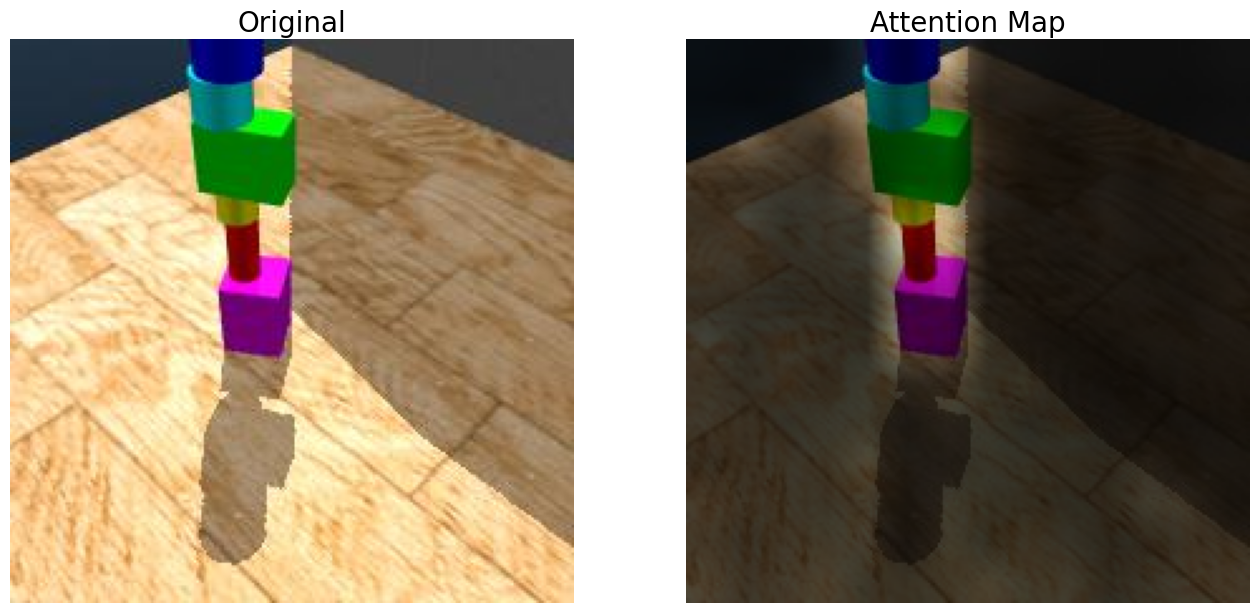

In [7]:
# Example usage
model = CustomViTModel(num_labels=6) 
model_path = '../model/visionT.pth' 

# Load the model weights
model = load_model_weights(model, model_path)

# Load an example image
img_path = '../test/36733.jpg'
img = Image.open(img_path).convert('RGB')

# Generate the attention map
attention_map = get_attention_map(model, img, get_mask=False)

# Plot the original image and the attention map
plot_attention_map(img, attention_map)